# Automatic differentiation: a backpropagation example for genetic programming

The purpose of this notebook is to demonstrate how weights can be learned for programs made up of differentiable nodes. In this case we're concerned with stack-based representations of mathematical functions, such as 

[ x1 x2 + sin ] $\rightarrow sin(x1+x2)$

or with embedded weights, $w_4 \cdot \sin( w_3 \cdot ( w_1 \cdot x_1 + w_2 \cdot x_2) ) $

In [24]:
# define node classes

class Variable():
    def __init__(self,loc=0,w=None):
        self.loc = loc
        self.name='x_'+str(loc)
        self.arity=0
        if w: self.w=w
        else: self.w=1.0
                
    def evaluate(self,stack,X=None):
        stack.append(self.w*X[:,self.loc])
        
    def derivative(self,stack,X=None):
        stack.append(self.X[:,self.loc])
    
class Add():
    def __init__(self,w=None):
        self.name='+'
        self.arity=2
        if w: self.w=w
        else: self.w = 1.0
            
    def evaluate(self,stack,X=None):
        stack.append(self.w*(stack.pop() + stack.pop()))
    
    def derivative(self,stack,X=None):
        stack.append(stack.pop() + stack.pop())

class Subtract():
    def __init__(self,w=None):
        self.name='-'
        self.arity=2
        if w: self.w=w
        else: self.w = 1.0
        
    def evaluate(self,stack,X=None):
        stack.append(self.w*(stack.pop() - stack.pop()))
    
    def derivative(self,stack,X=None):
        stack.append(stack.pop() - stack.pop())
        
class Multiply():
    def __init__(self,w=None):
        self.name='*'
        self.arity=2
        if w: self.w=w
        else: self.w = 1.0
            
    def evaluate(self,stack,X=None):
        stack.append(self.w*(stack.pop() + stack.pop()))
    
    def derivative(self,stack,X=None):
        stack.append(stack.pop() + stack.pop())

class Divide():
    def __init__(self,w=None):
        self.name='/'
        self.arity=2
        if w: self.w=w
        else: self.w = 1.0
 
    def evaluate(self,X,stack):
        stack.append(self.w*(stack.pop()/stack.pop()))
    
    def derivative(self,stack,X=None):
        stack.append(stack.pop() / stack.pop())
 
class Sin():
    def __init__(self,w=None):
        self.name='sin'
        self.arity=1
        if w: self.w=w
        else: self.w = 1.0
        
    def evaluate(self,stack,X=None):
        stack.append(self.w*(np.sin(stack.pop())))
    
    def derivative(self,stack,X=None):
        stack.append(-np.cos(self.stack.pop()))
        
class Cos():
    def __init__(self,w=None):
        self.name='cos'
        self.arity=1
        if w: self.w=w
        else: self.w = 1.0
            
    def evaluate(self,stack,X=None):
        stack.append(self.w*(np.cos(stack.pop())))
    
    def derivative(self,stack,X=None):
        stack.append(np.sin(stack.pop()))        

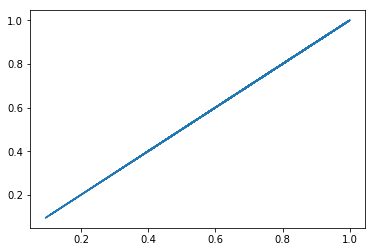

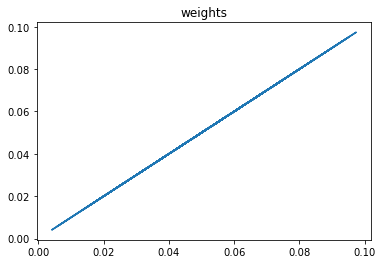

In [27]:
import numpy as np
X = np.random.rand(100,2)

ytest = np.sin(X[:,0]+X[:,1])

prog = [Variable(loc=1), Variable(loc=0), Add(), Sin()]
stack=[]
for p in prog:
    p.evaluate(stack,X)
yhat = np.array(stack[-1])

import matplotlib.pyplot as plt
%matplotlib inline
h0 = plt.figure()
plt.plot(ytest,yhat)


# test weights
w1, w2, w3, w4 = 0.67, 0.315, 0.89, 0.13

ytest = w4*np.sin(w3*(w2*X[:,0]+w1*X[:,1]))

prog = [Variable(loc=1,w=w1), Variable(loc=0,w=w2), Add(w=w3), Sin(w=w4)]
stack=[]
for p in prog:
    p.evaluate(stack,X)
yhat = np.array(stack[-1])

h1 = plt.figure()
plt.plot(ytest,yhat)
plt.title('weights')
plt.show()